## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

---

## Import Data

The csv file here is from the `Data Preprocessing.ipynb` file, which added some features to the csv from `Data Extraction.ipynb`.

In [2]:
df_full = pd.read_csv("statsbomb_open_shots_extended.csv")

In [3]:
df_full.columns

Index(['duration', 'id', 'index', 'location', 'match_id', 'minute',
       'off_camera', 'out', 'period', 'play_pattern', 'player', 'player_id',
       'position', 'possession', 'possession_team', 'possession_team_id',
       'related_events', 'second', 'shot_aerial_won', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 'shot_freeze_frame',
       'shot_key_pass_id', 'shot_one_on_one', 'shot_outcome',
       'shot_statsbomb_xg', 'shot_technique', 'shot_type', 'team', 'team_id',
       'timestamp', 'type', 'under_pressure', 'competition', 'season',
       'shot_deflected', 'shot_open_goal', 'shot_redirect',
       'shot_saved_off_target', 'shot_saved_to_post', 'shot_follows_dribble',
       'distance_to_goal', 'shot_angle', 'gk_location', 'gk_distance_to_goal',
       'gk_in_shot_triangle', 'players_in_shot_triangle',
       'opponents_in_radius', 'mode_position', 'general_position', 'goal'],
      dtype='object')

Take a subset of columns to include only those believed to be potentially relevant.

In [4]:
predictors = ["distance_to_goal",
              "shot_angle",
              "gk_distance_to_goal",
              "players_in_shot_triangle",
              "opponents_in_radius",
              "shot_body_part",
              "shot_first_time",
              "gk_in_shot_triangle",
              "shot_one_on_one",
              "shot_open_goal",
              "shot_technique",
              "under_pressure",
              "goal",
              "shot_statsbomb_xg"] # StatsBomb xG is included for comparing results

df = df_full[predictors].copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63309 entries, 0 to 63308
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   distance_to_goal          63309 non-null  float64
 1   shot_angle                63309 non-null  float64
 2   gk_distance_to_goal       63309 non-null  float64
 3   players_in_shot_triangle  63309 non-null  int64  
 4   opponents_in_radius       63309 non-null  int64  
 5   shot_body_part            63309 non-null  object 
 6   shot_first_time           20946 non-null  object 
 7   gk_in_shot_triangle       63309 non-null  bool   
 8   shot_one_on_one           3546 non-null   object 
 9   shot_open_goal            736 non-null    object 
 10  shot_technique            63309 non-null  object 
 11  under_pressure            16149 non-null  object 
 12  goal                      63309 non-null  bool   
 13  shot_statsbomb_xg         63309 non-null  float64
dtypes: boo

---

## Modelling

The first model to be used will be a very basic logistic regression, with just `distance_to_goal` as a predictor, as it is widely considered one of the most influential in determining xG.

In [6]:
X = df.distance_to_goal
y = df.goal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

print("Training size: ", X_train.shape[0])
print("Test size: ", X_test.shape[0])

Training size:  42206
Test size:  21103


Before modelling, we analyse the potential relationship between distance to goal and goal probability by binning distance to goal and taking the average of `goal` for each bin.

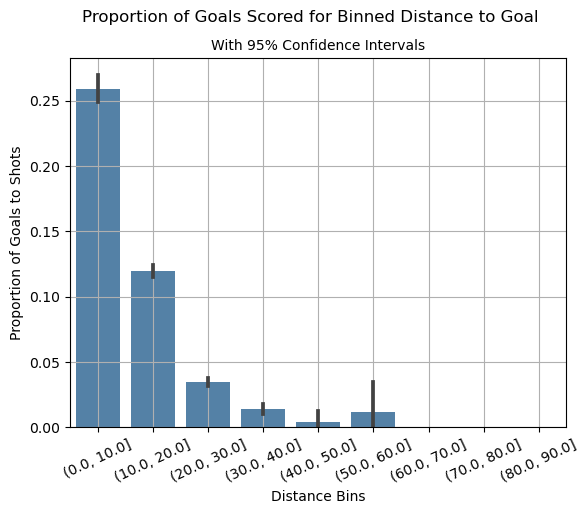

In [7]:
X_train_dist_bins = pd.cut(X_train, np.arange(0, max(X_train) + 10, 10))

sns.barplot(pd.concat([X_train_dist_bins, y_train], axis="columns"), x="distance_to_goal", y="goal", color="steelblue")

plt.suptitle("Proportion of Goals Scored for Binned Distance to Goal")
plt.title("With 95% Confidence Intervals", fontsize=10)
plt.xlabel("Distance Bins")
plt.ylabel("Proportion of Goals to Shots")
plt.xticks(rotation=25)
plt.grid()

plt.show()

There appears to be a non-linear relationship between distance and goal proportion, with an initial sharp drop followed by a flattening out after around 0.3 scaled distance.

Now, a logistic regression is fitted of the form:

$logit(p_i) = \beta_0 + \beta_1*distance_i$

Where $p_i$ is the probability of shot $i$ resulting in a goal.

`distance_to_goal` is also scaled to be in the range [0,1].

In [8]:
scaler = MinMaxScaler()
X = scaler.fit_transform(pd.DataFrame(df.distance_to_goal))
y = df.goal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

logit = sm.Logit(y_train, X_train).fit()

logit_preds = logit.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.293815
         Iterations 7


The predictions of this model are then evaluated against both the actual outcome of a shot using the Brier score, and against the StatsBomb xG model predictions using mean-squared error, mean-absolute error, and r-squared coefficient.

Also add a column for the Brier score of the StatsBomb model.

In [9]:
results = pd.DataFrame(index=["MSE","MAE","R-Squared", "Brier Score"])

results["StatsBomb"] = [np.nan,
                        np.nan,
                        np.nan,
                        brier_score_loss(y_test, df.shot_statsbomb_xg[y_test.index])]

results["Basic Logit"] = [mean_squared_error(df.shot_statsbomb_xg[y_test.index], logit_preds),
                          mean_absolute_error(df.shot_statsbomb_xg[y_test.index], logit_preds),
                          r2_score(df.shot_statsbomb_xg[y_test.index], logit_preds),
                          brier_score_loss(y_test, logit_preds)]

results.round(3)

,StatsBomb,Basic Logit
MSE,NaN,0.010
MAE,NaN,0.058
R-Squared,NaN,0.413
Brier Score,0.075,0.086


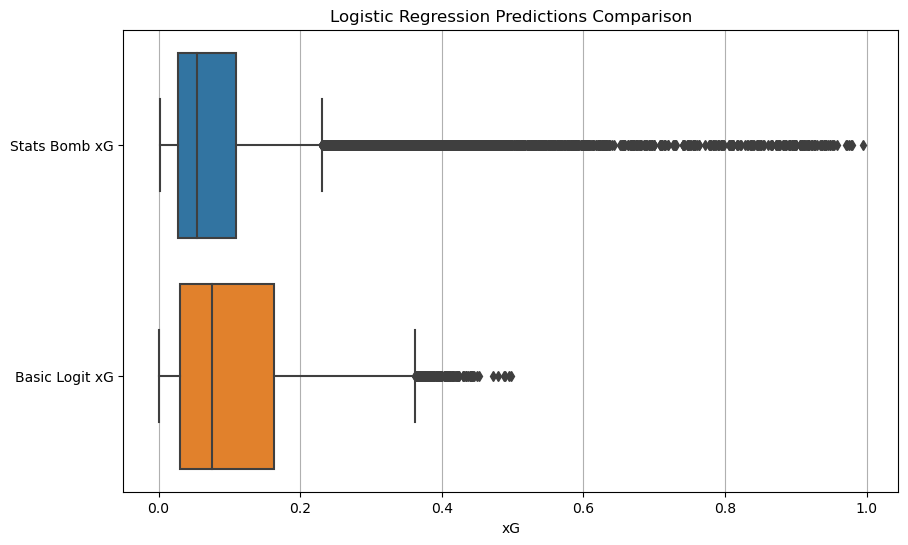

In [10]:
f, ax = plt.subplots(figsize=(10,6))

sns.boxplot(pd.concat([df.shot_statsbomb_xg[y_test.index], pd.Series(logit_preds)], axis="columns").rename(columns={"shot_statsbomb_xg":"Stats Bomb xG", 0:"Basic Logit xG"}),
            orient="horizontal")

plt.title("Logistic Regression Predictions Comparison")
plt.xlabel("xG")
plt.grid(axis="x")

plt.show()

Compared to the StatsBomb xG model, the basic logistic regression has a wider inter-quartile range, but fails to predict any probabilities above 0.6, unlike the Stats Bomb model. 

Clearly, more predictors are needed, starting with adding `shot_angle` to account for the fact that a close shot with a tight angle is harder to score than a close shot in front of goal.

In [11]:
X = df[["distance_to_goal", "shot_angle"]]
y = df.goal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

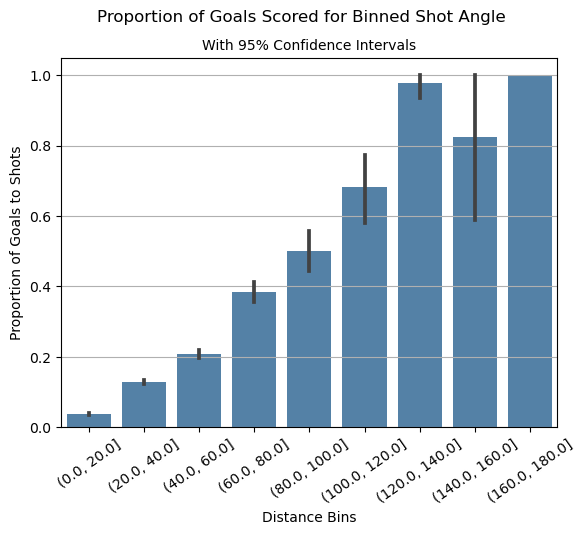

In [12]:
X_train_angle_bins = pd.cut(X_train.shot_angle, np.arange(0, max(X_train.shot_angle) + 20, 20))

sns.barplot(pd.concat([X_train_angle_bins, y_train], axis="columns"), x="shot_angle", y="goal", color="steelblue")

plt.suptitle("Proportion of Goals Scored for Binned Shot Angle")
plt.title("With 95% Confidence Intervals", fontsize=10)
plt.xlabel("Distance Bins")
plt.ylabel("Proportion of Goals to Shots")
plt.xticks(rotation=35)
plt.grid(axis="y")

plt.show()

Seems to be a much more linear relationship between goal probability and shot angle.

An issue here is that distance to goal and shot angle are correlated.

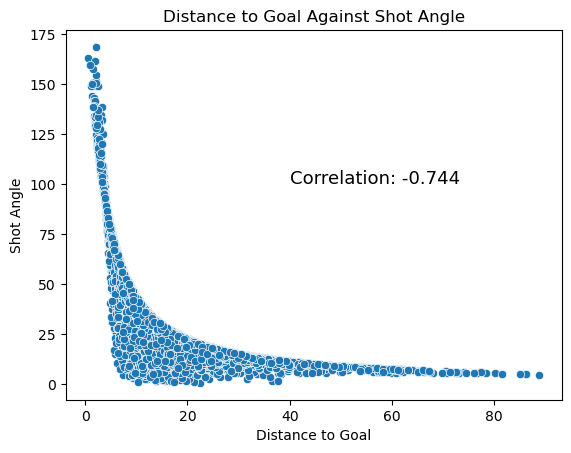

In [13]:
sns.scatterplot(X_train, x="distance_to_goal", y="shot_angle")

plt.text(x=40, y=100, s=f"Correlation: {np.corrcoef(X_train.distance_to_goal, X_train.shot_angle)[0,1].round(3)}", fontdict={"fontsize":13})

plt.title("Distance to Goal Against Shot Angle")
plt.xlabel("Distance to Goal")
plt.ylabel("Shot Angle")

plt.show()

The issue is that a shot with a given angle does not have the same goal probability as all other shots with the same angle, because it also depends on the distance. Therefore, an interaction term between the two is included to account for the joint effect of distance and angle.

In [14]:
X = pd.concat([df[["distance_to_goal","shot_angle"]], pd.DataFrame(df.distance_to_goal*df.shot_angle)], axis="columns", ignore_index=True)
X = pd.DataFrame(scaler.fit_transform(X)).rename(columns={0:"distance_to_goal", 1:"shot_angle", 2:"dist*angle"})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

logit_interaction = sm.Logit(y_train, X_train).fit()
logit_interaction_preds = logit_interaction.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.293484
         Iterations 8


In [15]:
results["Interaction Logit"] = [mean_squared_error(df.shot_statsbomb_xg[y_test.index], logit_interaction_preds),
                                mean_absolute_error(df.shot_statsbomb_xg[y_test.index], logit_interaction_preds),
                                r2_score(df.shot_statsbomb_xg[y_test.index], logit_interaction_preds),
                                brier_score_loss(y_test, logit_interaction_preds)]

results.round(3)

,StatsBomb,Basic Logit,Interaction Logit
MSE,NaN,0.010,0.009
MAE,NaN,0.058,0.058
R-Squared,NaN,0.413,0.428
Brier Score,0.075,0.086,0.086


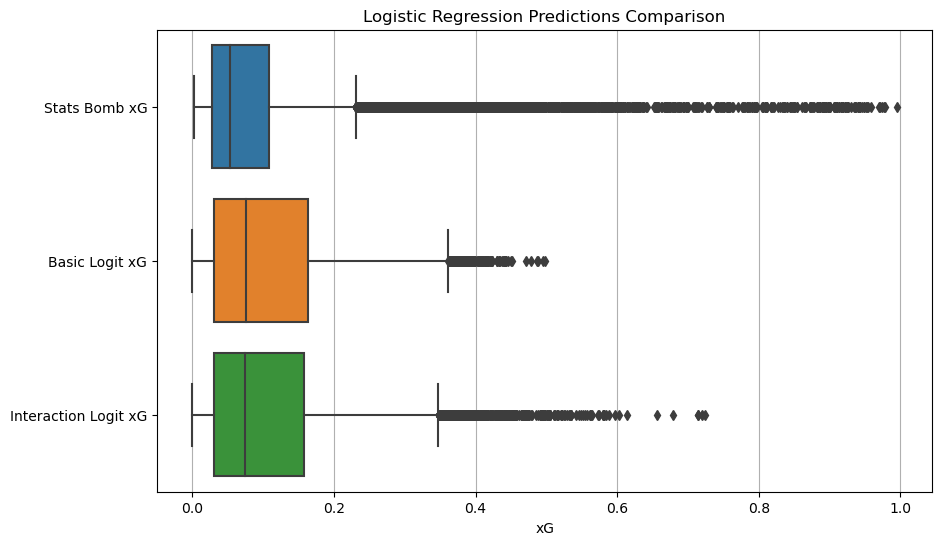

In [16]:
f, ax = plt.subplots(figsize=(10,6))

sns.boxplot(pd.concat([df.shot_statsbomb_xg[y_test.index], pd.Series(logit_preds), pd.Series(logit_interaction_preds)], axis="columns", ignore_index=True).rename(columns={0:"Stats Bomb xG", 1:"Basic Logit xG", 2:"Interaction Logit xG"}),
            orient="horizontal")

plt.title("Logistic Regression Predictions Comparison")
plt.xlabel("xG")
plt.grid(axis="x")

plt.show()

Including the interaction term does not affect the general spread of the predictions over the model without the interaction term, but it does predict higher xG values than before, which is closer to the predictions of the Stats Bomb model, so this is an improvement.

We still have a lot of information we can add, which we use now to create an extended logistic regression model.

In [17]:
df.head()

,distance_to_goal,shot_angle,gk_distance_to_goal,players_in_shot_triangle,opponents_in_radius,shot_body_part,shot_first_time,gk_in_shot_triangle,shot_one_on_one,shot_open_goal,shot_technique,under_pressure,goal,shot_statsbomb_xg
0,14.800338,25.119534,1.640122,3,0,Other Foot,True,True,NaN,NaN,Half Volley,NaN,False,0.087901
1,9.464143,44.698590,4.472136,1,0,Preferred Foot,True,True,NaN,NaN,Volley,NaN,True,0.160274
2,11.100450,8.905109,1.612452,1,0,Preferred Foot,True,False,NaN,NaN,Half Volley,True,False,0.016036
3,22.022716,17.246839,26.518673,0,0,Other Foot,NaN,False,NaN,NaN,Normal,NaN,True,0.527759
4,17.226143,16.956907,3.891015,1,0,Preferred Foot,NaN,True,NaN,NaN,Normal,NaN,False,0.074020


`gk_distance_to_goal` can be scaled and added to the interaction model.

In [18]:
X["gk_distance_to_goal"] = scaler.fit_transform(pd.DataFrame(df.gk_distance_to_goal))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

logit_extended = sm.Logit(y_train, X_train).fit()
logit_extended_preds = logit_extended.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.284282
         Iterations 8


In [19]:
results["Extended Logit"] = [mean_squared_error(df.shot_statsbomb_xg[y_test.index], logit_extended_preds),
                                mean_absolute_error(df.shot_statsbomb_xg[y_test.index], logit_extended_preds),
                                r2_score(df.shot_statsbomb_xg[y_test.index], logit_extended_preds),
                                brier_score_loss(y_test, logit_extended_preds)]

results.round(3)

,StatsBomb,Basic Logit,Interaction Logit,Extended Logit
MSE,NaN,0.010,0.009,0.008
MAE,NaN,0.058,0.058,0.055
R-Squared,NaN,0.413,0.428,0.513
Brier Score,0.075,0.086,0.086,0.083


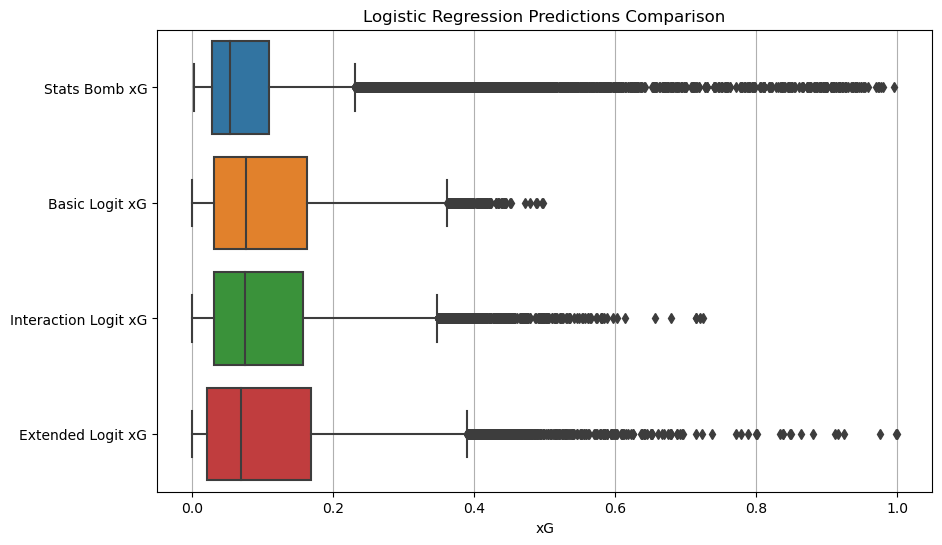

In [20]:
f, ax = plt.subplots(figsize=(10,6))

sns.boxplot(pd.concat([df.shot_statsbomb_xg[y_test.index],
                       pd.Series(logit_preds),
                       pd.Series(logit_interaction_preds),
                       logit_extended_preds], axis="columns", ignore_index=True).rename(
    columns={0:"Stats Bomb xG",
             1:"Basic Logit xG",
             2:"Interaction Logit xG",
             3:"Extended Logit xG"}),
            orient="horizontal")

plt.title("Logistic Regression Predictions Comparison")
plt.xlabel("xG")
plt.grid(axis="x")

plt.show()

Further improvements still with regard to predicting higher xG values.

Next, we look at `players_in_shot_triangle`.

In [21]:
df.players_in_shot_triangle.value_counts()

players_in_shot_triangle
1     30262
2     19481
3      6802
4      2918
0      1786
5      1217
6       513
7       211
8        77
9        29
10       11
11        2
Name: count, dtype: int64

Since this is a count variable, it will be considered as categorical. However, to reduce the number of categories and to obtain reliable estimates for categories where there are few observations, all shots with more than six players in the shot triangle will be coded as "7+". Then, `OneHotEncoder` is used to prepare it for use in the model.

In [22]:
X["players_in_shot_triangle"] = df.replace(np.arange(6, max(df.players_in_shot_triangle)) + 1, "7+").players_in_shot_triangle.astype(str)

encoder = OneHotEncoder(sparse_output=False)

X_array = np.hstack([np.asarray(X.drop("players_in_shot_triangle", axis="columns")), encoder.fit_transform(pd.DataFrame(X.players_in_shot_triangle))])

In [23]:
X_array.shape

(63309, 12)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_array, y.astype(int), test_size=1/3, random_state=1)

logit_extended = sm.Logit(y_train, X_train).fit()
logit_extended_preds = logit_extended.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.272428
         Iterations 8


In [25]:
results["Extended Logit"] = [mean_squared_error(df.shot_statsbomb_xg[y_test.index], logit_extended_preds),
                                mean_absolute_error(df.shot_statsbomb_xg[y_test.index], logit_extended_preds),
                                r2_score(df.shot_statsbomb_xg[y_test.index], logit_extended_preds),
                                brier_score_loss(y_test, logit_extended_preds)]

results.round(3)

,StatsBomb,Basic Logit,Interaction Logit,Extended Logit
MSE,NaN,0.010,0.009,0.005
MAE,NaN,0.058,0.058,0.039
R-Squared,NaN,0.413,0.428,0.705
Brier Score,0.075,0.086,0.086,0.079


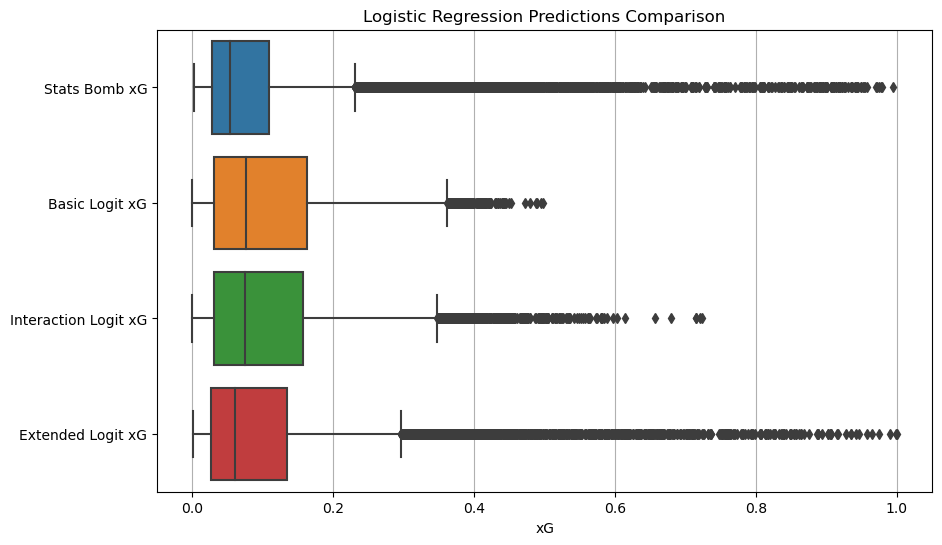

In [26]:
f, ax = plt.subplots(figsize=(10,6))

sns.boxplot(pd.concat([df.shot_statsbomb_xg[y_test.index],
                       pd.Series(logit_preds),
                       pd.Series(logit_interaction_preds),
                       pd.Series(logit_extended_preds)], axis="columns", ignore_index=True).rename(
    columns={0:"Stats Bomb xG",
             1:"Basic Logit xG",
             2:"Interaction Logit xG",
             3:"Extended Logit xG"}),
            orient="horizontal")

plt.title("Logistic Regression Predictions Comparison")
plt.xlabel("xG")
plt.grid(axis="x")

plt.show()

We can perform the same procedure on the other categorical non-binary features (`opponents_in_radius`,`shot_body_part`,`shot_technique`). We can also add the binary features to the model as integer 0 or 1 without the need for an encoder.

In [27]:
X_array = np.hstack([np.asarray(X.drop("players_in_shot_triangle", axis="columns")),
                     encoder.fit_transform(pd.concat([X.players_in_shot_triangle, df[["opponents_in_radius","shot_body_part","shot_technique"]]], axis="columns")),
                     np.asarray(df[["shot_first_time","gk_in_shot_triangle","shot_one_on_one","shot_open_goal","under_pressure"]].replace({True:1, False:0, np.nan:0}).astype(int))])

In [28]:
X_array.shape

(63309, 33)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_array, y.astype(int), test_size=1/3, random_state=1)

logit_extended = sm.Logit(y_train, X_train).fit()
logit_extended_preds = logit_extended.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.262144
         Iterations 9


In [30]:
results["Extended Logit"] = [mean_squared_error(df.shot_statsbomb_xg[y_test.index], logit_extended_preds),
                                mean_absolute_error(df.shot_statsbomb_xg[y_test.index], logit_extended_preds),
                                r2_score(df.shot_statsbomb_xg[y_test.index], logit_extended_preds),
                                brier_score_loss(y_test, logit_extended_preds)]

results.round(3)

,StatsBomb,Basic Logit,Interaction Logit,Extended Logit
MSE,NaN,0.010,0.009,0.003
MAE,NaN,0.058,0.058,0.029
R-Squared,NaN,0.413,0.428,0.826
Brier Score,0.075,0.086,0.086,0.076


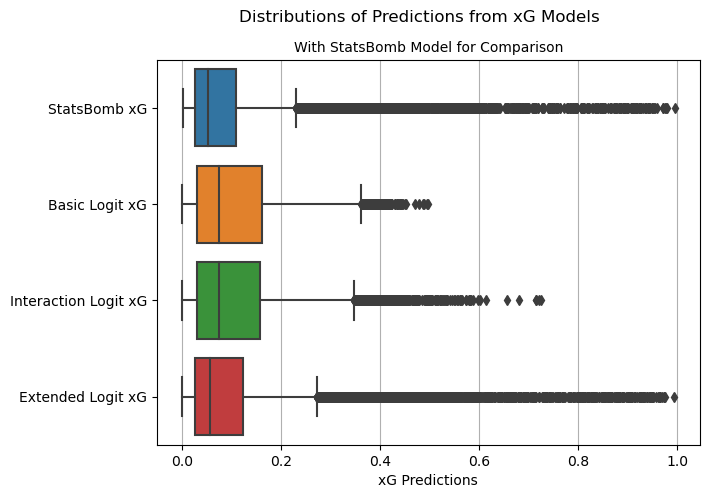

In [39]:
f, ax = plt.subplots(figsize=(7,5))

sns.boxplot(pd.concat([df.shot_statsbomb_xg[y_test.index],
                       pd.Series(logit_preds),
                       pd.Series(logit_interaction_preds),
                       pd.Series(logit_extended_preds)], axis="columns", ignore_index=True).rename(
    columns={0:"StatsBomb xG",
             1:"Basic Logit xG",
             2:"Interaction Logit xG",
             3:"Extended Logit xG"}),
            orient="horizontal")

plt.suptitle("Distributions of Predictions from xG Models")
plt.title("With StatsBomb Model for Comparison", fontsize=10)
plt.xlabel("xG Predictions")
plt.grid(axis="x")

plt.show()

The final result is much closer to the actual Stats Bomb xG distribution than the original models.